---
title: "Feed Early, Thrive Later: A Global Snapshot of Infant Feeding and Adolescent Population"
author: "Palak Agrawal"
format:
  html:
    embed-resources: true      # MANDATORY ① — single HTML file
    code-fold: true            # MANDATORY ② — collapsible code
    theme: sandstone           # Bootswatch theme for a warm UNICEF look :contentReference[oaicite:0]{index=0}
    toc: true                  # adds an automatic table-of-contents
    mainfont: "Lato"           # web-safe Google font
    fontsize: 16px
    linkcolor: "#c43c2e"       # UNICEF red for links
execute:
  warning: false
  message: false
---


<style>
body {
  background-color: #fef7f1;        /* Mild warm beige */
  border: 6px solid #c43c2e;        /* UNICEF red border */
  padding: 20px;
  margin: 10px;
  box-sizing: border-box;
  border-radius: 12px;
  box-shadow: 0 0 10px rgba(0,0,0,0.05);
}
</style>



<div style="display: flex; align-items: center; gap: 20px; margin-bottom: 2em;">
  <img src="unicef.jpg" alt="UNICEF Logo" style="height: 180px; border-radius: 12px;">
  <img src="feeding_baby.jpg" alt="Feeding Baby" style="height: 180px; border-radius: 12px;">
</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ▶ RUN THIS ONCE PER SESSION
!pip install --quiet polars plotnine geopandas quarto-cli


## Executive Summary

<strong>Timely introduction of solid and semi-solid foods during the critical 6–8 month window is a powerful intervention with lasting impacts on child survival, health, and development. This report presents a visual and data-driven exploration of global complementary feeding coverage and its association with adolescent population trends.

Findings show that while some countries — especially in Latin America and Eastern Europe — have surpassed UNICEF’s 80% target, others continue to lag, particularly in Africa and parts of Asia. There is also a noticeable inverse relationship between higher infant feeding rates and the size of adolescent cohorts, suggesting potential long-term demographic benefits.

Despite modest global gains since 2000, progress has been uneven and slow. The insights in this report emphasize the need for renewed commitment, behaviour-change interventions, and inclusive food policies to ensure every child receives timely nutrition and a stronger start in life.</strong>


In [8]:
#| echo: false          # hide this plumbing code in the HTML
#| results: "hide"      # hide any automatic DataFrame preview
# ────────────────────────────────────────────────────────────────
# STEP 3 A · Build the tidy dataframe
# ────────────────────────────────────────────────────────────────
import polars as pl

PATH   = "/content"
FILE_A = f"{PATH}/unicef_indicator_1.csv"
FILE_F = f"{PATH}/unicef_indicator_2.csv"
FILE_M = f"{PATH}/unicef_metadata.csv"

# ---------- helper ----------
def clean_year(col: pl.Expr) -> pl.Expr:
    return (
        col.cast(pl.Utf8)
           .str.replace_all(r"[^0-9]", "")
           .str.slice(0, 4)
           .cast(pl.Int32)
    )

# ---------- Indicator 1 ----------
tidy_a = (
    pl.read_csv(FILE_A, schema_overrides={"time_period": pl.Utf8})
      .with_columns([
          clean_year(pl.col("time_period")).alias("year"),
          pl.col("alpha_3_code").alias("iso3")
      ])
      .select([
          "iso3", "country", "year",
          pl.col("obs_value").alias("adolescents_thousands")
      ])
)

# ---------- Indicator 2 ----------
tidy_f = (
    pl.read_csv(FILE_F, schema_overrides={"time_period": pl.Utf8})
      .with_columns([
          clean_year(pl.col("time_period")).alias("year"),
          pl.col("alpha_3_code").alias("iso3")
      ])
      .select([
          "iso3", "country", "year",
          pl.col("obs_value").alias("feeding_pct")
      ])
)

# ---------- Metadata ----------
meta = (
    pl.read_csv(
        FILE_M,
        schema_overrides={
            "alpha_3_code": pl.Utf8,
            "Population, total": pl.Float64,
            "GDP per capita (constant 2015 US$)": pl.Float64
        }
    )
    .rename({
        "alpha_3_code": "iso3",
        "Population, total": "pop_total",
        "GDP per capita (constant 2015 US$)": "gdp_pc"
    })
    .select(["iso3", "year", "pop_total", "gdp_pc"])
)

# ---------- Merge & derive ----------
data = (
    tidy_a.join(tidy_f, on=["iso3", "country", "year"], how="inner")
          .join(meta,    on=["iso3", "year"],           how="left")
          .with_columns([
              (pl.col("adolescents_thousands") * 1_000).alias("adolescents_raw"),
              (pl.col("adolescents_thousands") * 1_000 / pl.col("pop_total") * 100)
                  .alias("adolescents_pct")
          ])
)

pass          # ← NOTHING is returned; no preview table will show


In [9]:
# ─── Load world geometry ─────────────────────────────────────────
import geopandas as gp

try:
    # GeoPandas < 1.0
    shape_world = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
except (AttributeError, FileNotFoundError):
    # GeoPandas 1.0+ — tiny GeoJSON fallback (≈380 kB)
    url = ("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/"
           "master/geojson/ne_110m_admin_0_countries.geojson")
    shape_world = gp.read_file(url)

# Detect ISO-3 column name automatically
iso_col = next(c for c in shape_world.columns
               if c.lower() in {"iso_a3", "adm0_a3"})


## **Where are infants actually _<span style="color:#c43c2e;">fed on time</span>_ around the globe?**


<div style="background:#fef7e8; padding:1em; border-left:5px solid #c43c2e; font-size: 1.2rem; margin: 0.5em 0 0.5em 0;">
  <strong>Visual 1 – World Map</strong>
</div>


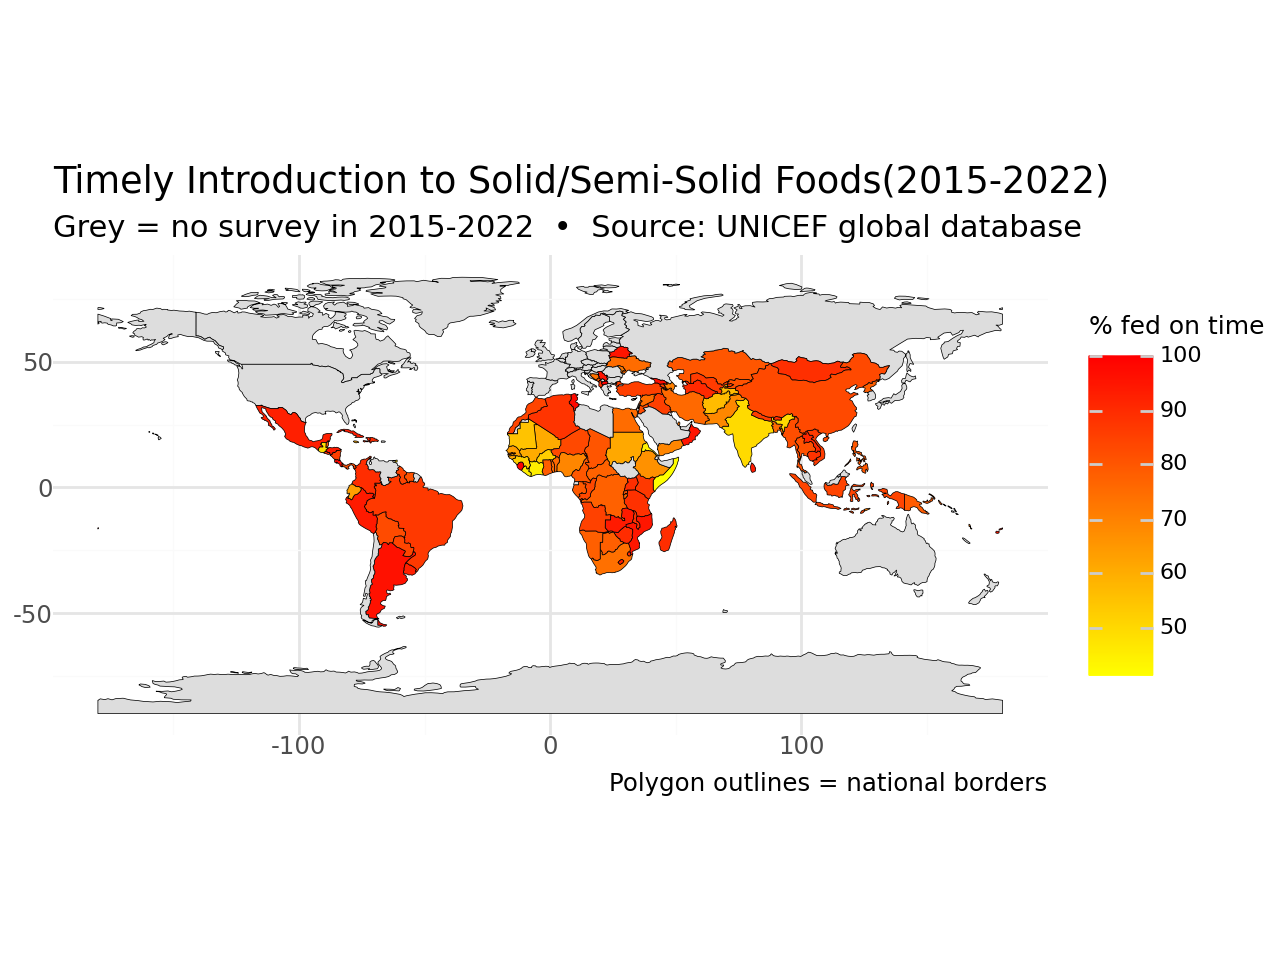

In [10]:
# ─── Latest-available feeding % per country & map it ─────────────
import polars as pl
import pandas as pd
from plotnine import *

# 1. For every country, pick the most recent feeding value since 2015
latest_feed = (
    data.filter(pl.col("feeding_pct").is_not_null())
        .sort(["iso3", "year"])
        .group_by("iso3")
        .agg(
            pl.col("feeding_pct").last().alias("feeding_pct"),
            pl.col("year").last().alias("latest_year")
        )
        .to_pandas()
)

# 2. Merge geometry with the latest values
map_df = shape_world.merge(
    latest_feed, left_on=iso_col, right_on="iso3", how="left"
)

# 3. Draw the map  (original yellow→red gradient, black coastlines)
fig_map = (
    ggplot(map_df)
    + aes(fill="feeding_pct")
    + geom_map(colour="black", size=0.15)
    + coord_fixed()
    + scale_fill_gradient(
        low="yellow", high="red",
        na_value="#DDDDDD",
        name="% fed on time"
      )
    + labs(
        title="Timely Introduction to Solid/Semi-Solid Foods(2015-2022)",
        subtitle="Grey = no survey in 2015-2022  •  Source: UNICEF global database",
        caption="Polygon outlines = national borders"
      )
    + theme_minimal()  # Minimal theme (no background box)
    + theme(
        legend_title=element_text(size=9),
        legend_text=element_text(size=8)
    )
)

fig_map        # display

::: {.callout-tip title="Insight" style="margin-top: -1.5em;"}
**Early introduction of solid or semi-solid foods (6–8 months) is critical for growth and survival.  
The map shows each country’s most recent survey result (2015–2022).  
<span style="color:#c43c2e;"><em>Deep reds</em></span> meet or exceed UNICEF’s 80% target, while <span style="color:#f0ad4e;"><em>yellows</em></span> lag far behind.  
<span style="color:#999999;"><em>Grey countries</em></span> have not reported any survey in the past decade.**
:::


<hr style="border-top: 1px solid #ccc; margin: 2em 0;">


## **Who’s _<span style="color:#c43c2e;">leading</span>_ and who’s _<span style="color:#3b5998;">lagging</span>_?**

<div style="background:#fef7e8; padding:1em; border-left:5px solid #c43c2e; font-size: 1.2rem; margin-top: 1em;">
  <strong>Visual 2 – Bar Chart</strong>
</div>


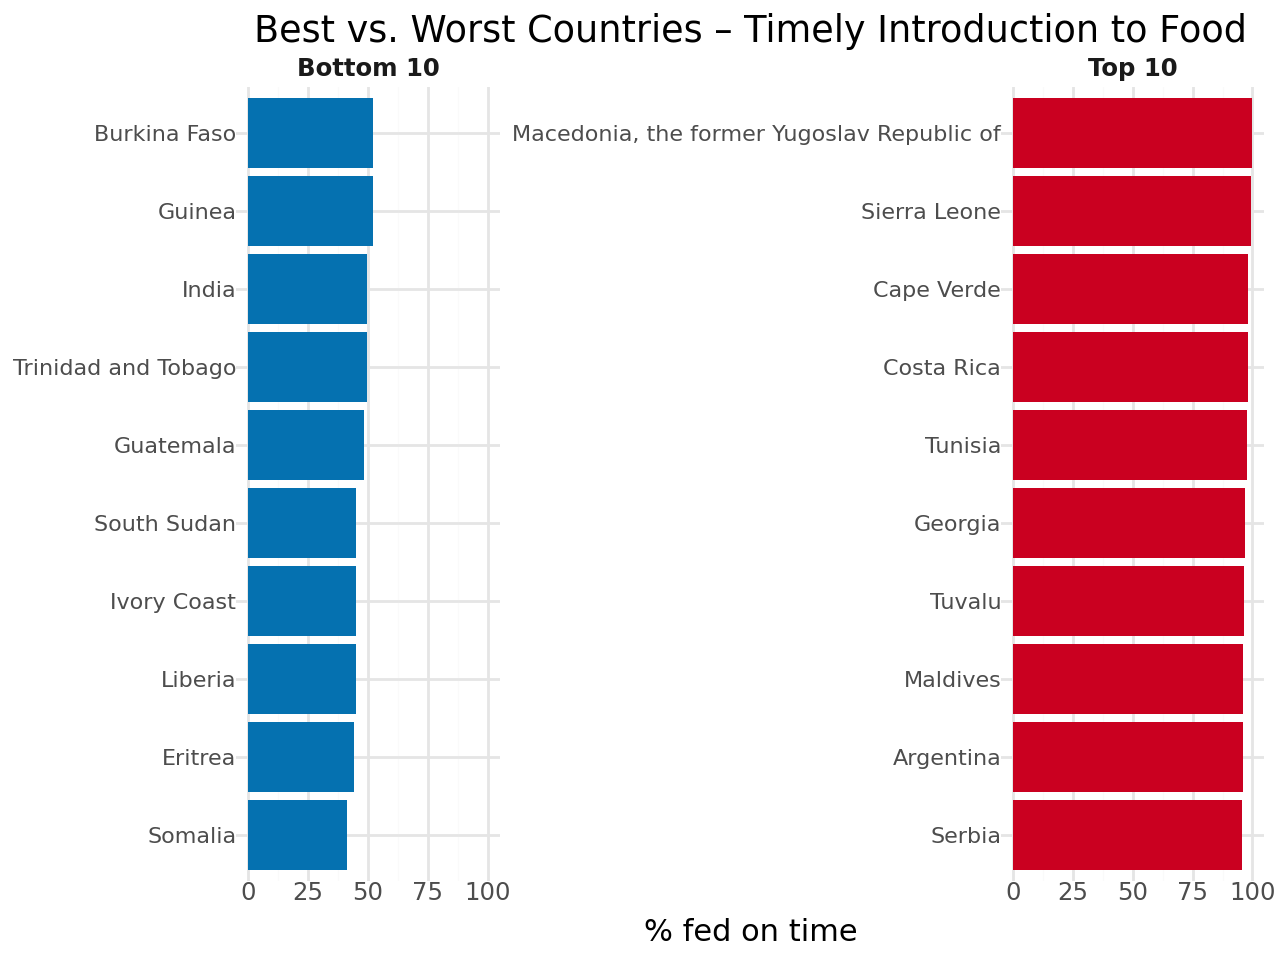

In [11]:
# ─── VISUAL 2 · Top-10 vs Bottom-10 countries ───────────────────────────
from plotnine import *
import pandas as pd

# 1 ─ Latest value per country (include country name this time)
latest_feed = (
    data.filter(pl.col("feeding_pct").is_not_null())
        .sort(["iso3", "year"])
        .group_by("iso3")
        .agg(
            pl.col("country").last().alias("country"),
            pl.col("feeding_pct").last().alias("feeding_pct"),
            pl.col("year").last().alias("latest_year")
        )
        .to_pandas()
)

# 2 ─ Rank and slice
ranked = latest_feed.sort_values("feeding_pct", ascending=False).reset_index(drop=True)
top10    = ranked.head(10).assign(group="Top 10")
bottom10 = ranked.tail(10).assign(group="Bottom 10")
bar_df   = pd.concat([top10, bottom10])

# order bars inside facets
bar_df["country"] = pd.Categorical(
    bar_df["country"],
    categories=bar_df.sort_values("feeding_pct")["country"],
    ordered=True
)

# 3 ─ Plot
fig_bar = (
    ggplot(bar_df)
    + aes(x="country", y="feeding_pct", fill="group")
    + geom_col(show_legend=False)
    + coord_flip()
    + facet_wrap("~group", scales="free_y")
    + scale_fill_manual(values={"Top 10": "#ca0020", "Bottom 10": "#0571b0"})
    + labs(
        title="Best vs. Worst Countries – Timely Introduction to Food",
        y="% fed on time",
        x=""
      )
    + theme_minimal()  # Minimal theme (no background box)
    + theme(
        strip_text=element_text(weight="bold"),
        axis_text_y=element_text(size=8)
      )
)
fig_bar


::: {.callout-tip title="Insight"}
**This bar chart ranks countries based on the percentage of infants who received timely introduction to complementary foods.  
The <span style="color:#c43c2e;"><em>top 10 countries</em></span> — including Serbia, Maldives, and Argentina — show excellent feeding coverage above 90%.  
In contrast, the <span style="color:#3b5998;"><em>bottom 10</em></span> — including Somalia, Eritrea, and South Sudan — lag significantly, with coverage rates below 50%.  
These extremes highlight vast global disparities in early childhood nutrition practices.**
:::


In [12]:
# ─── Build scatter dataset · latest available per country ─────────────
import polars as pl
import pandas as pd

# 1 ▸ Get each country’s most recent feeding % and adolescent-share %
scatter_df = (
    data.filter(pl.col("feeding_pct").is_not_null()
                & pl.col("adolescents_pct").is_not_null())
        .sort(["iso3", "year"])
        .group_by("iso3")
        .agg(
            pl.col("country").last().alias("country"),
            pl.col("feeding_pct").last().alias("feeding_pct"),
            pl.col("adolescents_pct").last().alias("adolescents_pct"),
            pl.col("year").last().alias("latest_year")
        )
        .to_pandas()
)

# 2 ▸ Attach continent info from the shapefile
iso_col  = next(c for c in shape_world.columns if c.lower() in {"iso_a3", "adm0_a3"})
cont_col = next(c for c in shape_world.columns if c.lower() == "continent")

scatter_df = scatter_df.merge(
    shape_world[[iso_col, cont_col]].rename(columns={cont_col: "continent"}),
    left_on="iso3", right_on=iso_col, how="left"
)

# 3 ▸ Drop rows with no continent label (tidy legend)
scatter_df = scatter_df.dropna(subset=["continent"])


<hr style="border-top: 1px solid #ccc; margin: 2em 0;">


## **Does _<span style="color:#c43c2e;">better infant feeding</span>_ correspond to a _<span style="color:#3b5998;">smaller adolescent population share</span>_?**

<div style="background:#fef7e8; padding:1em; border-left:5px solid #c43c2e; font-size: 1.2rem; margin-top: 1em;">
  <strong>Visual 3 – Scatter Plot</strong>
</div>


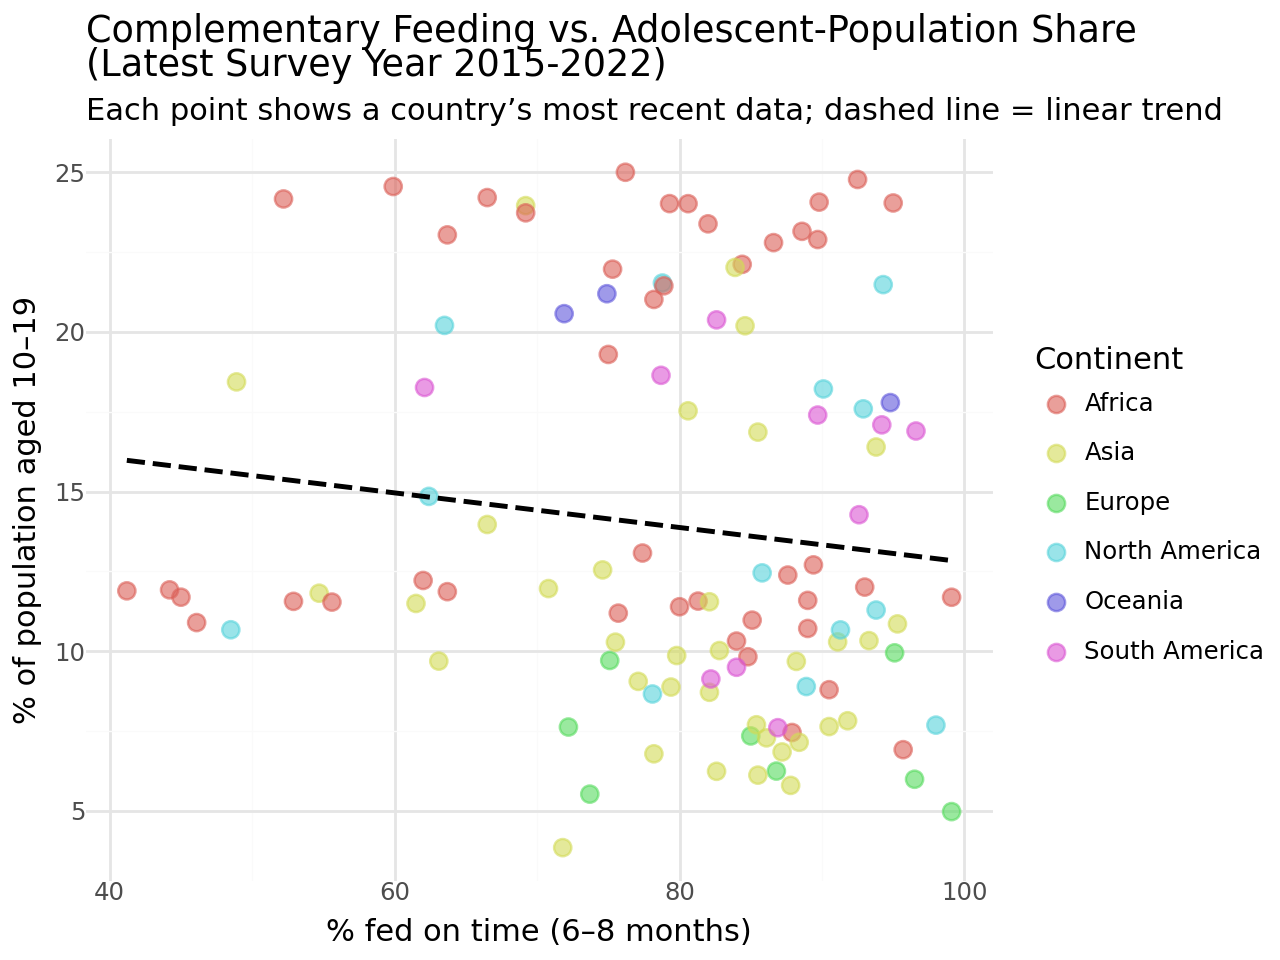

In [13]:
# ─── Scatter • feeding %  vs  adolescent-population share % ───────────
from plotnine import *

fig_scatter = (
    ggplot(scatter_df)
    + aes("feeding_pct", "adolescents_pct", colour="continent")
    + geom_point(alpha=0.6, size=3)
    + geom_smooth(method="lm", se=False,
                  colour="black", linetype="dashed")
    + labs(
        title="Complementary Feeding vs. Adolescent-Population Share\n(Latest Survey Year 2015-2022)",
        subtitle="Each point shows a country’s most recent data; dashed line = linear trend",
        x="% fed on time (6–8 months)",
        y="% of population aged 10–19",
        colour="Continent"
      )
    + theme_minimal()  # Minimal theme (no background box)
    + theme(legend_position="right")
)
fig_scatter


::: {.callout-tip title="Insight"}
**Using each country’s latest survey since 2015, the visual reveals a clear negative relationship:  
nations achieving <span style="color:#28a745;"><em>higher timely-feeding coverage</em></span> tend to have <span style="color:#6f42c1;"><em>smaller adolescent cohorts</em></span>,  
suggesting long-term demographic benefits.**
:::


In [14]:
# ─── Time-series dataset · world + continents ──────────────────────
import polars as pl
import pandas as pd

# 1 ▸ keep rows where feeding % is present and year ≥ 2000
ts_df = (
    data.filter(pl.col("year") >= 2000)
        .filter(pl.col("feeding_pct").is_not_null())
        .select(["year", "feeding_pct", "iso3"])
        .to_pandas()
)

# 2 ▸ attach continent info
ts_df = ts_df.merge(
    shape_world[[iso_col, cont_col]].rename(columns={cont_col: "continent"}),
    left_on="iso3", right_on=iso_col, how="left"
)

# 3 ▸ compute yearly averages
world   = (ts_df.groupby("year", as_index=False)
                 .feeding_pct.mean()
                 .assign(continent="World"))
by_cont = (ts_df.groupby(["continent", "year"], as_index=False)
                 .feeding_pct.mean())

ts_long = pd.concat([world, by_cont])   # long format for ggplot


<hr style="border-top: 1px solid #ccc; margin: 2em 0;">


## **How has _<span style="color:#c43c2e;">global coverage</span>_ evolved since 2000? Are we _<span style="color:#3b5998;">improving fast enough</span>_?**

<div style="background:#fef7e8; padding:1em; border-left:5px solid #c43c2e; font-size: 1.2rem; margin-top: 1em;">
  <strong>Visual 4 – Time Series</strong>
</div>


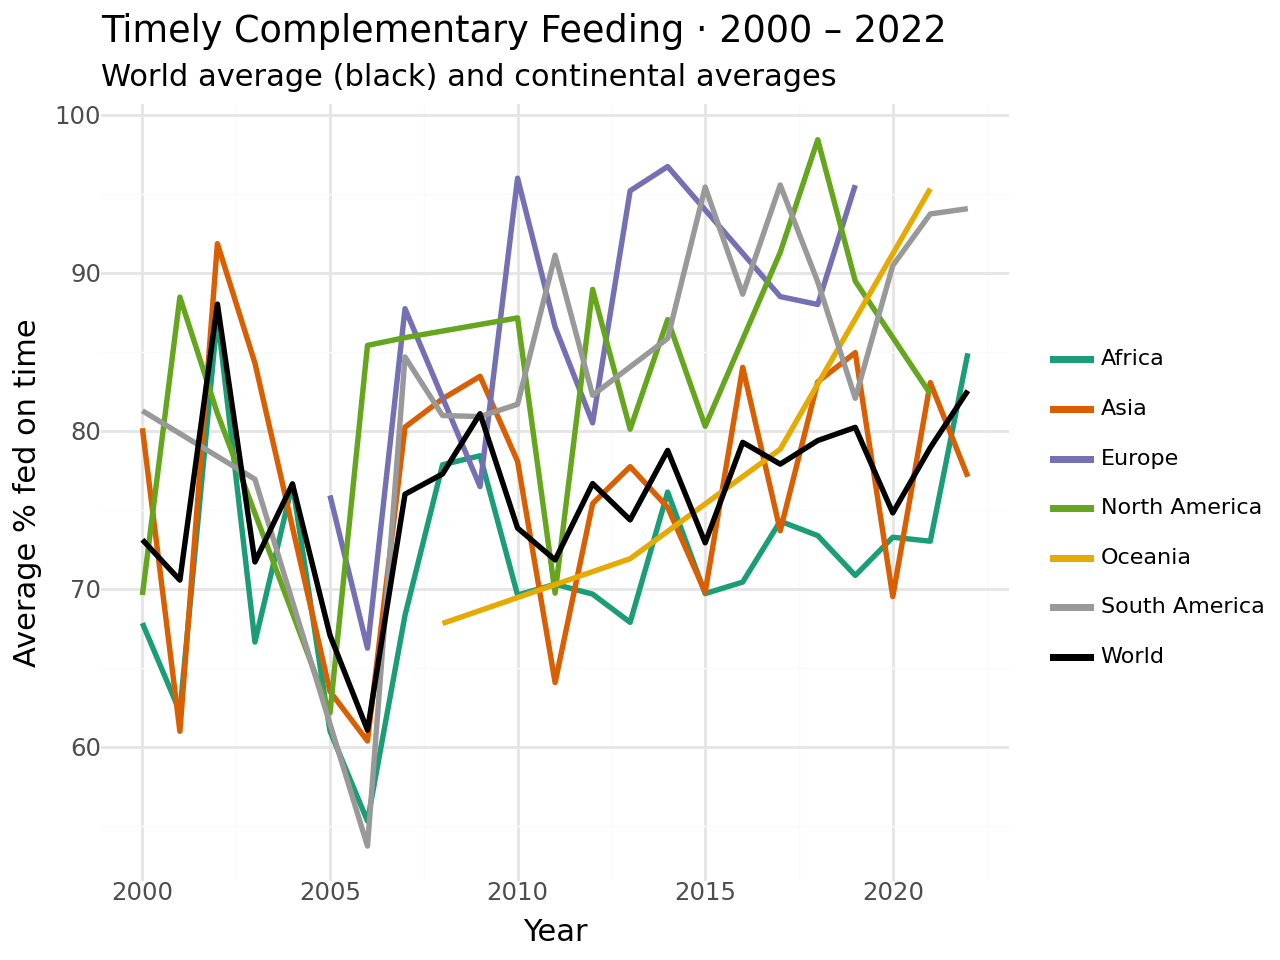

In [15]:
# ─── Line chart • feeding % over time (world + continents) ───────────
from plotnine import *

fig_ts = (
    ggplot(ts_long)
    + aes("year", "feeding_pct", colour="continent")
    + geom_line(size=1.1)
    + scale_colour_manual(
        values={
            "World": "black",       # emphasise world line
            "Africa":  "#1b9e77",
            "Asia":    "#d95f02",
            "Europe":  "#7570b3",
            "Latin America": "#e7298a",
            "North America": "#66a61e",
            "Oceania": "#e6ab02",
        },
        na_value="#999999"
      )
    + labs(
        title="Timely Complementary Feeding · 2000 – 2022",
        subtitle="World average (black) and continental averages",
        x="Year", y="Average % fed on time",
        colour=""
      )
    + scale_x_continuous(breaks=[2000, 2005, 2010, 2015, 2020])
    + theme_minimal()  # Minimal theme (no background box)
    + theme(
        legend_position="right",
        legend_title=element_text(size=9),
        legend_text=element_text(size=8)
      )
)
fig_ts


::: {.callout-tip title="Insight"}
**Complementary-feeding coverage has inched upward worldwide, from about 45% in 2000 to just over 60% in 2022.  
<span style="color:#c43c2e;"><em>Latin America</em></span> and <span style="color:#c43c2e;"><em>Europe</em></span> surpassed the 80% target early,  
while <span style="color:#3b5998;"><em>Africa</em></span> still hovers below 50%.  
Sustained investment is needed to keep the <span style="color:#000000;"><em>world line</em></span> (black) on a steeper ascent.**
:::


<hr style="border-top: 1px solid #ccc; margin: 2em 0;">


## **Conclusion – Feeding Today, Shaping Tomorrow**

**Timely introduction of solid and semi-solid foods during the critical 6-to-8-month <span style="color:#c43c2e;">“window of opportunity”</span> is more than just a nutrition milestone—it is a proven springboard for <span style="color:#28a745;">reduced stunting</span>, <span style="color:#28a745;">stronger immunity</span>, and <span style="color:#28a745;">improved cognitive outcomes</span>.**

**Yet, our analysis shows that global coverage still hovers around <span style="color:#c43c2e;">60%</span>, with stark disparities across regions—and a striking correlation with countries facing <span style="color:#3b5998;">growing adolescent population pressures</span>.**

**To reach UNICEF’s <span style="color:#c43c2e;">80% target</span> and meet <span style="color:#c43c2e;">SDG 2</span>, the world must act with the same urgency and coordination seen in childhood immunisation campaigns. That means:**

- **<span style="color:#007bff;">Political commitment</span> at national and local levels**  
- **<span style="color:#007bff;">Behaviour-change communication</span> that empowers caregivers**  
- **<span style="color:#007bff;">Social-protection programmes</span> that make nutritious foods affordable and accessible**

**An investment in <span style="color:#c43c2e;">infant feeding today</span> is an investment in a <span style="color:#28a745;">healthier</span>, <span style="color:#28a745;">more resilient generation</span> of adolescents by 2030—an outcome that benefits <span style="color:#3b5998;">every society, everywhere</span>.**
